# Задача классификации со случайным лесом

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

heart_df = pd.read_csv('dataset/heart_disease_uci.csv')

heart_df['target'] = (heart_df['num'] > 0).astype(int)
heart_df = heart_df.drop(['id', 'dataset', 'num'], axis=1)

### Взглянем на данные


Распределение целевой переменной:
target
1    509
0    411
Name: count, dtype: int64

Процентное соотношение:
target
1    55.326087
0    44.673913
Name: proportion, dtype: float64


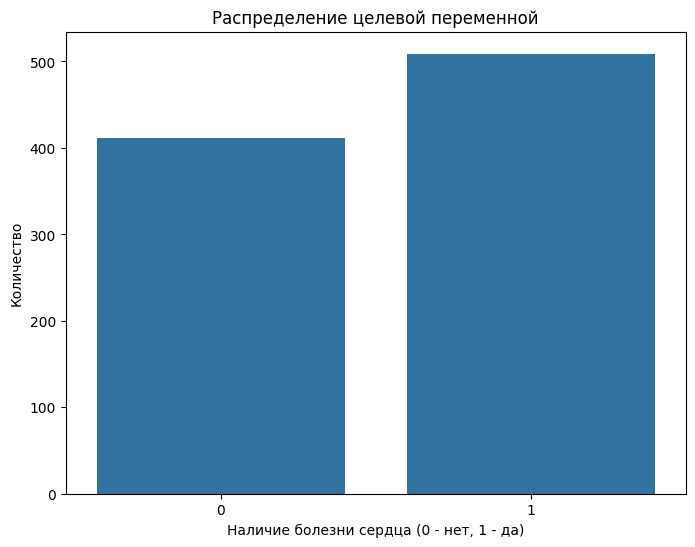


Категориальные признаки: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Числовые признаки: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']


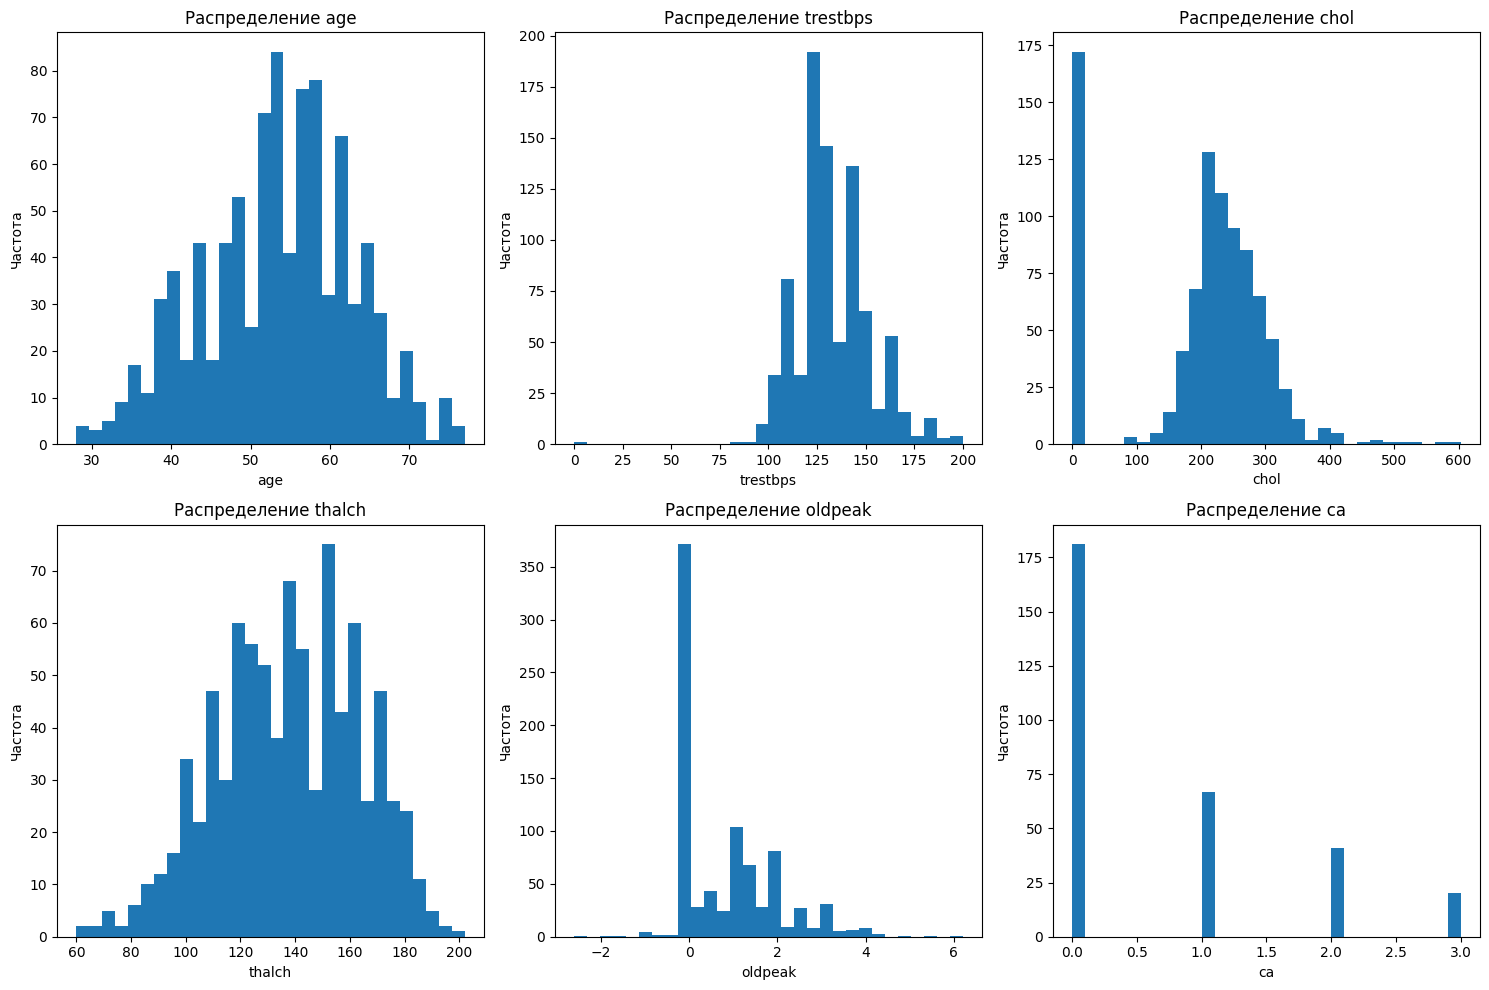

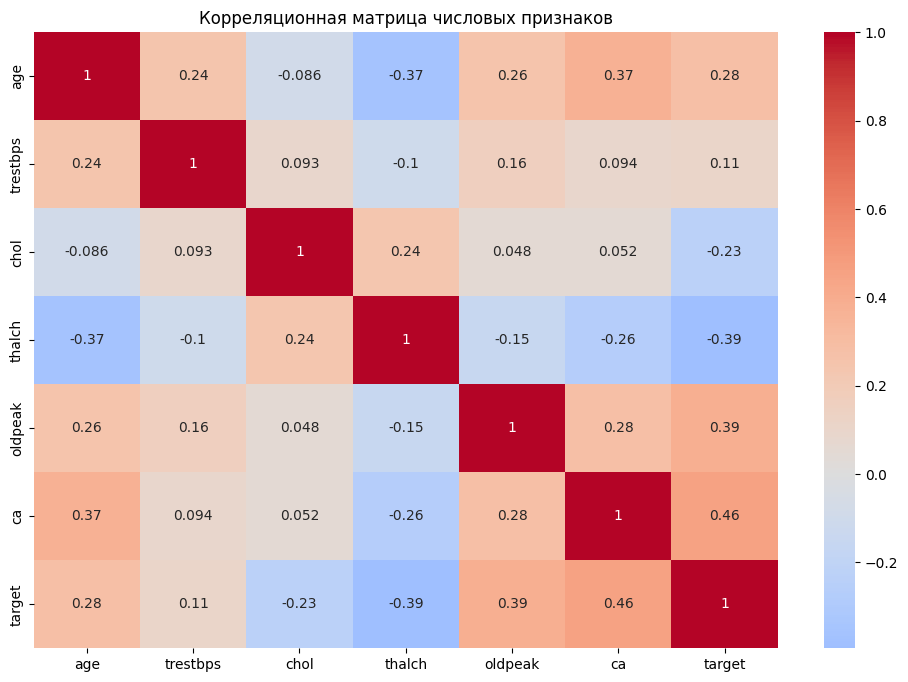

In [43]:
print("\nРаспределение целевой переменной:")
print(heart_df['target'].value_counts())
print("\nПроцентное соотношение:")
print(heart_df['target'].value_counts(normalize=True) * 100)

plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=heart_df)
plt.title('Распределение целевой переменной')
plt.xlabel('Наличие болезни сердца (0 - нет, 1 - да)')
plt.ylabel('Количество')
plt.show()

X_class = heart_df.drop(['target'], axis=1)
y_class = heart_df['target']

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numeric_features = [col for col in X_class.columns if col not in categorical_features]

print(f"\nКатегориальные признаки: {categorical_features}")
print(f"Числовые признаки: {numeric_features}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(numeric_features[:6]):
    row, col_idx = i // 3, i % 3
    axes[row, col_idx].hist(heart_df[col].dropna(), bins=30)
    axes[row, col_idx].set_title(f'Распределение {col}')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Частота')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
numeric_df = heart_df[numeric_features + ['target']]
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

### Созданим бейзлайн случайного леса

In [44]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"Размер тренировочной выборки: {X_train_c.shape}")
print(f"Размер тестовой выборки: {X_test_c.shape}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rfc)
])

rf_pipeline.fit(X_train_c, y_train_c)

y_pred_c = rf_pipeline.predict(X_test_c)
y_pred_proba_c = rf_pipeline.predict_proba(X_test_c)[:, 1]

print("\nКачество бейзлайн модели (Random Forest):")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c):.4f}")
print(f"Precision: {precision_score(y_test_c, y_pred_c):.4f}")
print(f"Recall: {recall_score(y_test_c, y_pred_c):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_c):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_c):.4f}")

Размер тренировочной выборки: (736, 13)
Размер тестовой выборки: (184, 13)

Качество бейзлайн модели (Random Forest):
Accuracy: 0.8424
Precision: 0.8476
Recall: 0.8725
F1 Score: 0.8599
ROC-AUC: 0.9136


### Посмотрим матрицу ошибок и отчет классификации

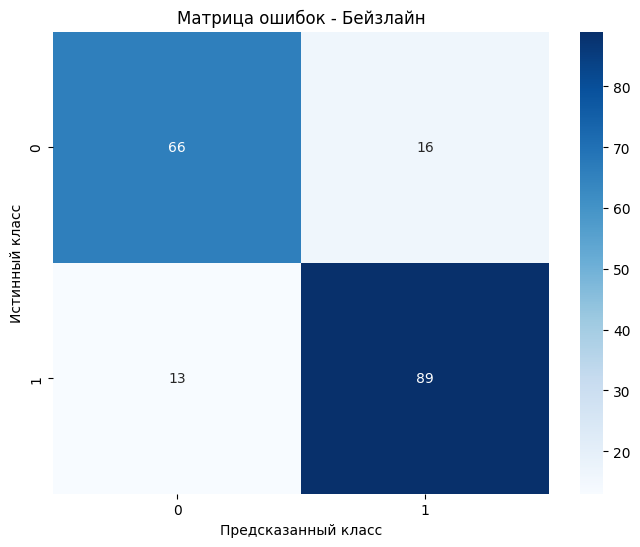


Отчет о классификации:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        82
           1       0.85      0.87      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



In [45]:
conf_matrix = confusion_matrix(y_test_c, y_pred_c)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок - Бейзлайн')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

print("\nОтчет о классификации:")
print(classification_report(y_test_c, y_pred_c))

### Взглянем на важность признаков

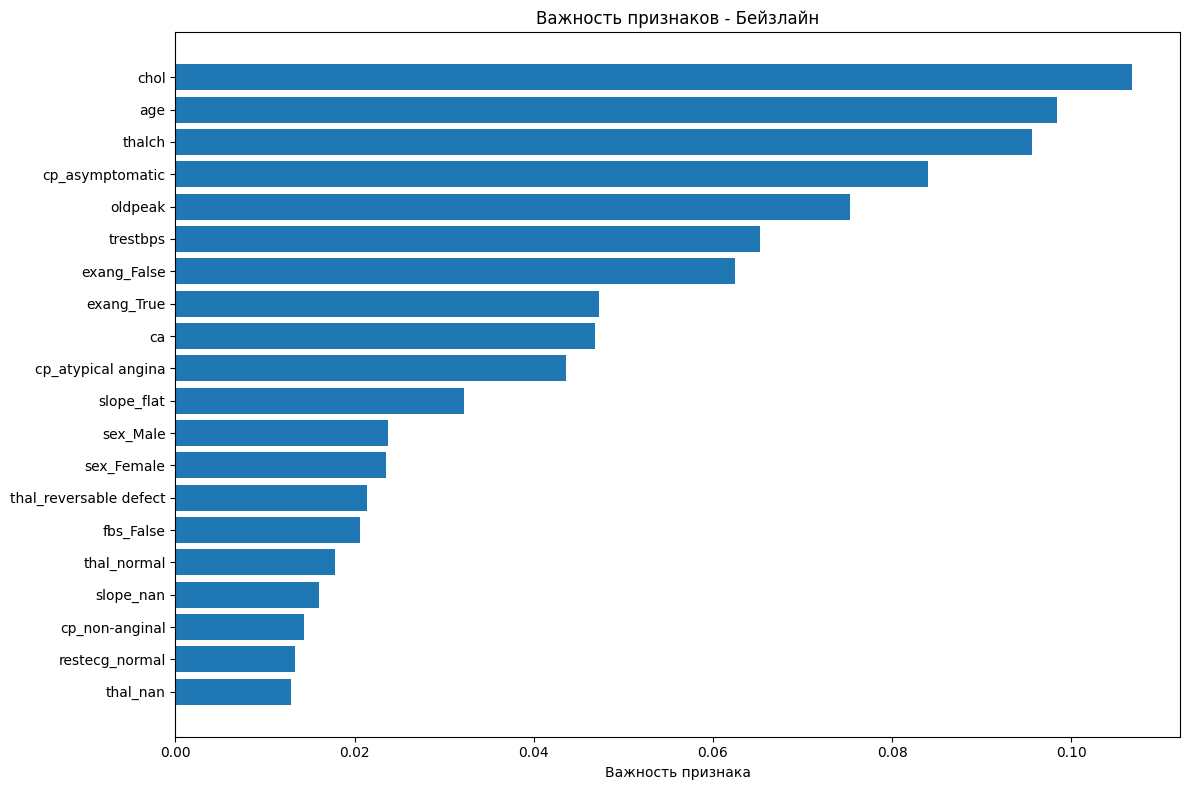

In [46]:
rf_model = rf_pipeline.named_steps['classifier']
preprocessor = rf_pipeline.named_steps['preprocessor']
preprocessor.fit(X_train_c)
feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if name == 'cat':
        encoder = transformer
        cat_features = encoder.get_feature_names_out(features)
        feature_names.extend(cat_features)
    else:
        feature_names.extend(features)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Важность признаков - Бейзлайн')
plt.barh(range(min(20, len(feature_names))), importances[indices][:20][::-1])
plt.yticks(range(min(20, len(feature_names))), [feature_names[i] for i in indices[:20][::-1]])
plt.xlabel('Важность признака')
plt.tight_layout()
plt.show()


### Попробуем улучшить бейзлайн

Гипотезы для улучшения:
- Использование более сложной стратегии импутации
- Стандартизация числовых признаков
- Подбор гиперпараметров
- Использование кросс-валидации
- Балансировка классов
- Отбор признаков


А если вместо `SimpleImputer` использовать `KNNImputer`?

In [47]:
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', KNNImputer(n_neighbors=5), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

rf_pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor_knn),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_pipeline_knn.fit(X_train_c, y_train_c)
y_pred_knn = rf_pipeline_knn.predict(X_test_c)

print(f"Accuracy с KNNImputer: {accuracy_score(y_test_c, y_pred_knn):.4f}")
print(f"F1 Score с KNNImputer: {f1_score(y_test_c, y_pred_knn):.4f}")

Accuracy с KNNImputer: 0.8587
F1 Score с KNNImputer: 0.8738


### А что, если нормализовать числовые признаки?

In [48]:
print("\nГипотеза 2: Стандартизация числовых признаков")

preprocessor_std = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

rf_pipeline_std = Pipeline(steps=[
    ('preprocessor', preprocessor_std),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_pipeline_std.fit(X_train_c, y_train_c)
y_pred_std = rf_pipeline_std.predict(X_test_c)

print(f"Accuracy со стандартизацией: {accuracy_score(y_test_c, y_pred_std):.4f}")
print(f"F1 Score со стандартизацией: {f1_score(y_test_c, y_pred_std):.4f}")


Гипотеза 2: Стандартизация числовых признаков
Accuracy со стандартизацией: 0.8478
F1 Score со стандартизацией: 0.8654


### А что, если подобрать гиперпараметры?

In [49]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None]
}

base_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

random_search = RandomizedSearchCV(
    base_pipeline,
    param_distributions=param_grid,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Начинаем подбор гиперпараметров...")
random_search.fit(X_train_c, y_train_c)

print(f"\nЛучшие параметры: {random_search.best_params_}")
print(f"Лучший F1 Score на кросс-валидации: {random_search.best_score_:.4f}")

y_pred_tuned = random_search.predict(X_test_c)
y_pred_proba_tuned = random_search.predict_proba(X_test_c)[:, 1]

print(f"\nКачество на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test_c, y_pred_tuned):.4f}")
print(f"Recall: {recall_score(y_test_c, y_pred_tuned):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_tuned):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_tuned):.4f}")

Начинаем подбор гиперпараметров...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Лучшие параметры: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20}
Лучший F1 Score на кросс-валидации: 0.8458

Качество на тестовой выборке:
Accuracy: 0.8533
Precision: 0.8505
Recall: 0.8922
F1 Score: 0.8708
ROC-AUC: 0.9311


### А что, если попробовать сбалансиоовать классы?

In [50]:
rf_pipeline_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42, 
        n_jobs=-1,
        class_weight='balanced'
    ))
])

rf_pipeline_balanced.fit(X_train_c, y_train_c)
y_pred_balanced = rf_pipeline_balanced.predict(X_test_c)

print(f"Accuracy с балансировкой классов: {accuracy_score(y_test_c, y_pred_balanced):.4f}")
print(f"F1 Score с балансировкой классов: {f1_score(y_test_c, y_pred_balanced):.4f}")
print(f"Recall с балансировкой классов: {recall_score(y_test_c, y_pred_balanced):.4f}")

Accuracy с балансировкой классов: 0.8261
F1 Score с балансировкой классов: 0.8462
Recall с балансировкой классов: 0.8627


### А что, если отобрать признаки?

In [51]:
rf_for_selection = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_for_selection.fit(preprocessor.fit_transform(X_train_c), y_train_c)

selector = SelectFromModel(rf_for_selection, threshold='median', prefit=True)
X_train_selected = selector.transform(preprocessor.transform(X_train_c))
X_test_selected = selector.transform(preprocessor.transform(X_test_c))

print(f"Исходное количество признаков: {preprocessor.transform(X_train_c).shape[1]}")
print(f"Количество признаков после отбора: {X_train_selected.shape[1]}")

rf_selected = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_selected.fit(X_train_selected, y_train_c)
y_pred_selected = rf_selected.predict(X_test_selected)

print(f"Accuracy с отбором признаков: {accuracy_score(y_test_c, y_pred_selected):.4f}")
print(f"F1 Score с отбором признаков: {f1_score(y_test_c, y_pred_selected):.4f}")

Исходное количество признаков: 29
Количество признаков после отбора: 15
Accuracy с отбором признаков: 0.8478
F1 Score с отбором признаков: 0.8654


### Итак, улучшенный бейзлайн


Качество улучшенной модели:
Accuracy: 0.8533
Precision: 0.8505
Recall: 0.8922
F1 Score: 0.8708
ROC-AUC: 0.9259


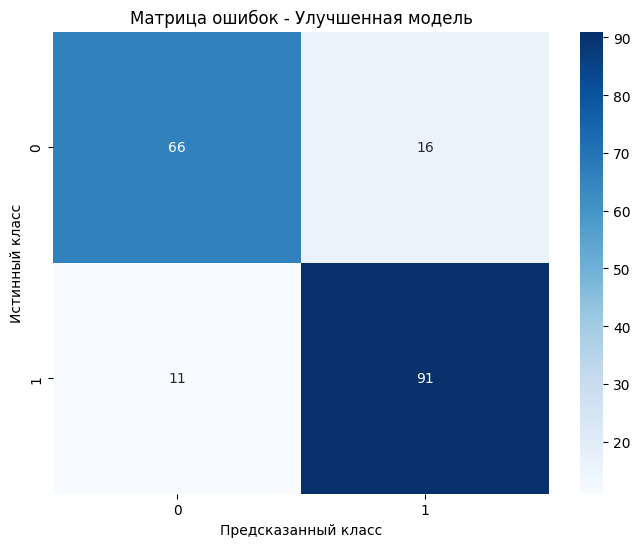

In [52]:
improved_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

improved_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

improved_pipeline = Pipeline(steps=[
    ('preprocessor', improved_preprocessor),
    ('classifier', improved_rf)
])

improved_pipeline.fit(X_train_c, y_train_c)

y_pred_improved = improved_pipeline.predict(X_test_c)
y_pred_proba_improved = improved_pipeline.predict_proba(X_test_c)[:, 1]

print("\nКачество улучшенной модели:")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_improved):.4f}")
print(f"Precision: {precision_score(y_test_c, y_pred_improved):.4f}")
print(f"Recall: {recall_score(y_test_c, y_pred_improved):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_improved):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_improved):.4f}")

conf_matrix_improved = confusion_matrix(y_test_c, y_pred_improved)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_improved, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок - Улучшенная модель')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

### Сравним модели


Сравнение моделей:
                Модель  Accuracy  Precision   Recall  F1 Score  ROC-AUC
              Бейзлайн  0.842391   0.847619 0.872549  0.859903 0.913618
        Стандартизация  0.847826   0.849057 0.882353  0.865385 0.912363
Подбор гиперпараметров  0.853261   0.850467 0.892157  0.870813 0.931133
  Балансировка классов  0.826087   0.830189 0.862745  0.846154 0.920014
            Улучшенная  0.853261   0.850467 0.892157  0.870813 0.925933


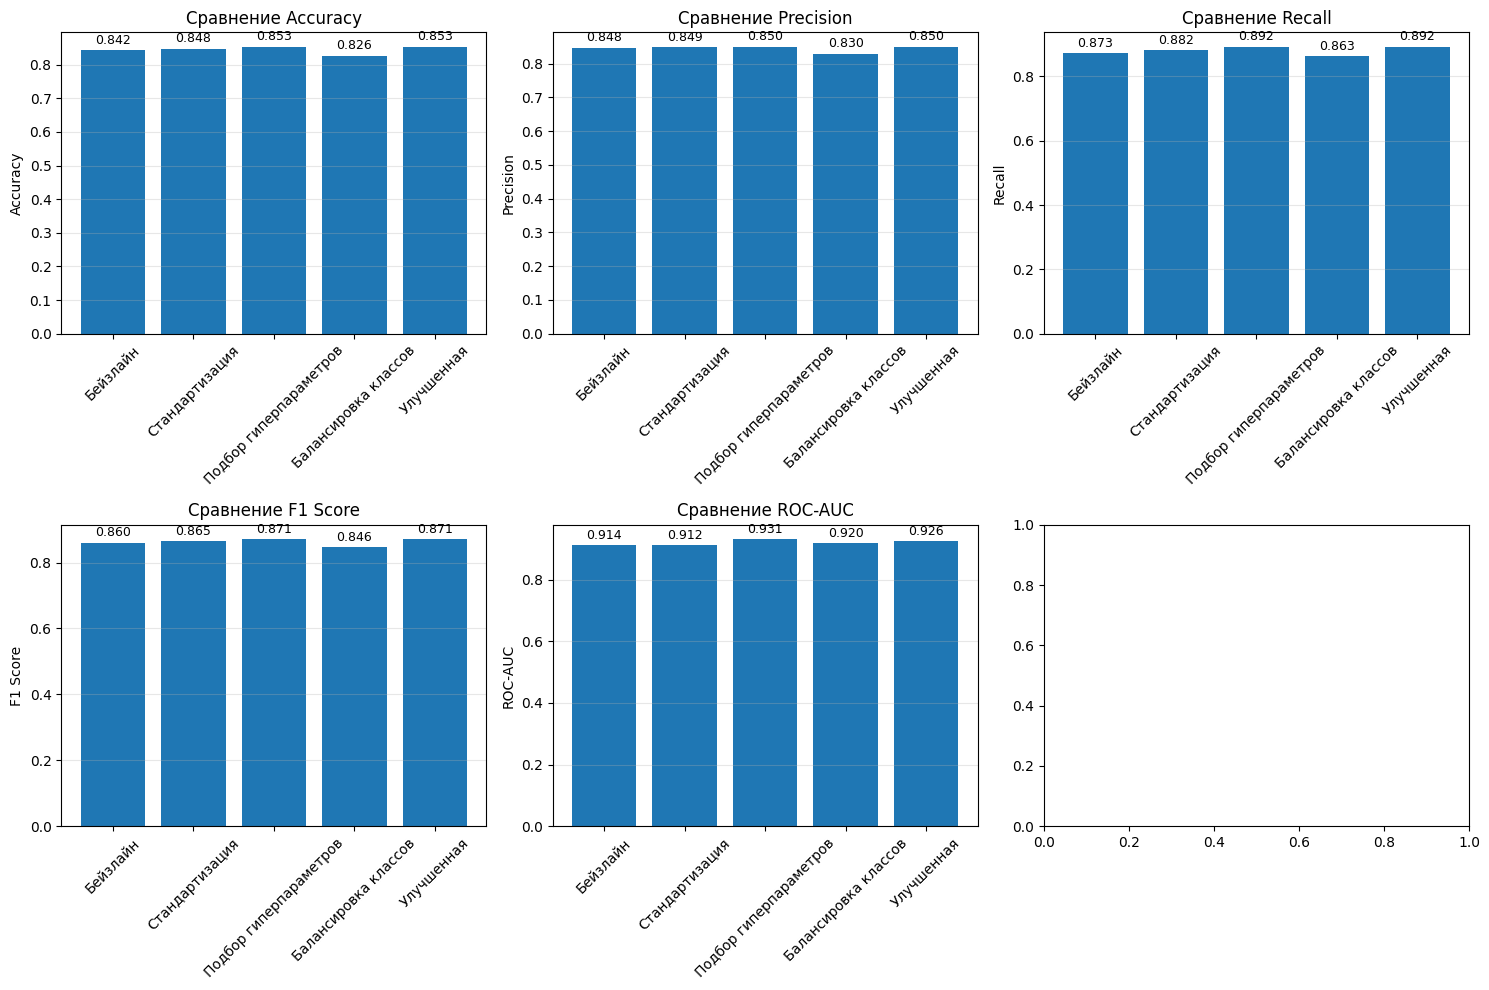

In [53]:
comparison_df = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Стандартизация', 'Подбор гиперпараметров', 'Балансировка классов', 'Улучшенная'],
    'Accuracy': [
        accuracy_score(y_test_c, y_pred_c),
        accuracy_score(y_test_c, y_pred_std),
        accuracy_score(y_test_c, y_pred_tuned),
        accuracy_score(y_test_c, y_pred_balanced),
        accuracy_score(y_test_c, y_pred_improved)
    ],
    'Precision': [
        precision_score(y_test_c, y_pred_c),
        precision_score(y_test_c, y_pred_std),
        precision_score(y_test_c, y_pred_tuned),
        precision_score(y_test_c, y_pred_balanced),
        precision_score(y_test_c, y_pred_improved)
    ],
    'Recall': [
        recall_score(y_test_c, y_pred_c),
        recall_score(y_test_c, y_pred_std),
        recall_score(y_test_c, y_pred_tuned),
        recall_score(y_test_c, y_pred_balanced),
        recall_score(y_test_c, y_pred_improved)
    ],
    'F1 Score': [
        f1_score(y_test_c, y_pred_c),
        f1_score(y_test_c, y_pred_std),
        f1_score(y_test_c, y_pred_tuned),
        f1_score(y_test_c, y_pred_balanced),
        f1_score(y_test_c, y_pred_improved)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test_c, y_pred_proba_c),
        roc_auc_score(y_test_c, rf_pipeline_std.predict_proba(X_test_c)[:, 1]),
        roc_auc_score(y_test_c, y_pred_proba_tuned),
        roc_auc_score(y_test_c, rf_pipeline_balanced.predict_proba(X_test_c)[:, 1]),
        roc_auc_score(y_test_c, y_pred_proba_improved)
    ]
})

print("\nСравнение моделей:")
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for i, metric in enumerate(metrics):
    row, col = i // 3, i % 3
    axes[row, col].bar(comparison_df['Модель'], comparison_df[metric])
    axes[row, col].set_title(f'Сравнение {metric}')
    axes[row, col].set_ylabel(metric)
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].grid(axis='y', alpha=0.3)
    
    for j, v in enumerate(comparison_df[metric]):
        axes[row, col].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Далее реализуем свой алгоритм

In [54]:
class CustomDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        
    def _gini(self, y):
        classes = np.unique(y)
        gini = 1.0
        for cls in classes:
            p = np.sum(y == cls) / len(y)
            gini -= p ** 2
        return gini
    
    def _split(self, X, y, feature_idx, threshold):
        left_mask = X[:, feature_idx] <= threshold
        right_mask = X[:, feature_idx] > threshold
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]
    
    def _best_split(self, X, y):
        best_gini = float('inf')
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = self._split(X, y, feature_idx, threshold)
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                gini_left = self._gini(y_left)
                gini_right = self._gini(y_right)
                total_gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(y)
                
                if total_gini < best_gini:
                    best_gini = total_gini
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        if (self.max_depth is not None and depth >= self.max_depth or
            n_samples < self.min_samples_split or
            n_classes == 1):
            return np.bincount(y).argmax()
        
        feature, threshold = self._best_split(X, y)
        
        if feature is None:
            return np.bincount(y).argmax()
        
        X_left, X_right, y_left, y_right = self._split(X, y, feature, threshold)
        
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)
        
        return {
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree
        }
    
    def _predict_sample(self, x, node):
        if isinstance(node, dict):
            if x[node['feature']] <= node['threshold']:
                return self._predict_sample(x, node['left'])
            else:
                return self._predict_sample(x, node['right'])
        else:
            return node
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y)
        return self
    
    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])


class CustomRandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, max_features='sqrt', random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]
    
    def _get_random_features(self, n_features):
        if self.max_features == 'sqrt':
            max_features = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            max_features = int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            max_features = self.max_features
        else:
            max_features = n_features
        
        features = np.random.choice(n_features, max_features, replace=False)
        return features
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        for i in range(self.n_estimators):
            X_bootstrap, y_bootstrap = self._bootstrap_samples(X, y)
            
            features = self._get_random_features(n_features)
            X_bootstrap = X_bootstrap[:, features]
            
            tree = CustomDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf
            )
            
            tree.fit(X_bootstrap, y_bootstrap)
            
            self.trees.append(tree)
            self.feature_indices.append(features)
        
        return self
    
    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.zeros((self.n_estimators, n_samples))
        
        for i, (tree, features) in enumerate(zip(self.trees, self.feature_indices)):
            X_subset = X[:, features]
            predictions[i] = tree.predict(X_subset)
        
        final_predictions = []
        for sample_idx in range(n_samples):
            votes = predictions[:, sample_idx]
            final_predictions.append(np.bincount(votes.astype(int)).argmax())
        
        return np.array(final_predictions)
    
    def predict_proba(self, X):
        n_samples = X.shape[0]
        predictions = np.zeros((self.n_estimators, n_samples))
        
        for i, (tree, features) in enumerate(zip(self.trees, self.feature_indices)):
            X_subset = X[:, features]
            predictions[i] = tree.predict(X_subset)
        
        probas = np.zeros((n_samples, 2))
        for sample_idx in range(n_samples):
            votes = predictions[:, sample_idx]
            probas[sample_idx, 1] = np.sum(votes == 1) / self.n_estimators
            probas[sample_idx, 0] = 1 - probas[sample_idx, 1]
        
        return probas

### Обучим модель

In [55]:
preprocessor_simple = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

X_train_processed = preprocessor_simple.fit_transform(X_train_c)
X_test_processed = preprocessor_simple.transform(X_test_c)

print(f"Размер обработанной тренировочной выборки: {X_train_processed.shape}")
print(f"Размер обработанной тестовой выборки: {X_test_processed.shape}")

my_rf = CustomRandomForest(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

my_rf.fit(X_train_processed, y_train_c.values)

y_pred_my = my_rf.predict(X_test_processed)
y_pred_proba_my = my_rf.predict_proba(X_test_processed)[:, 1]

print("\nКачество имплементированной модели:")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_my):.4f}")
print(f"Precision: {precision_score(y_test_c, y_pred_my):.4f}")
print(f"Recall: {recall_score(y_test_c, y_pred_my):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_my):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_my):.4f}")

Размер обработанной тренировочной выборки: (736, 29)
Размер обработанной тестовой выборки: (184, 29)

Качество имплементированной модели:
Accuracy: 0.8587
Precision: 0.8519
Recall: 0.9020
F1 Score: 0.8762
ROC-AUC: 0.9240


### Сравним с бейзлайном sklearn


Сравнение имплементированной модели с бейзлайном:
            Модель  Accuracy  Precision   Recall  F1 Score  ROC-AUC
Бейзлайн (sklearn)  0.842391   0.847619 0.872549  0.859903 0.913618
Имплементированная  0.858696   0.851852 0.901961  0.876190 0.923960


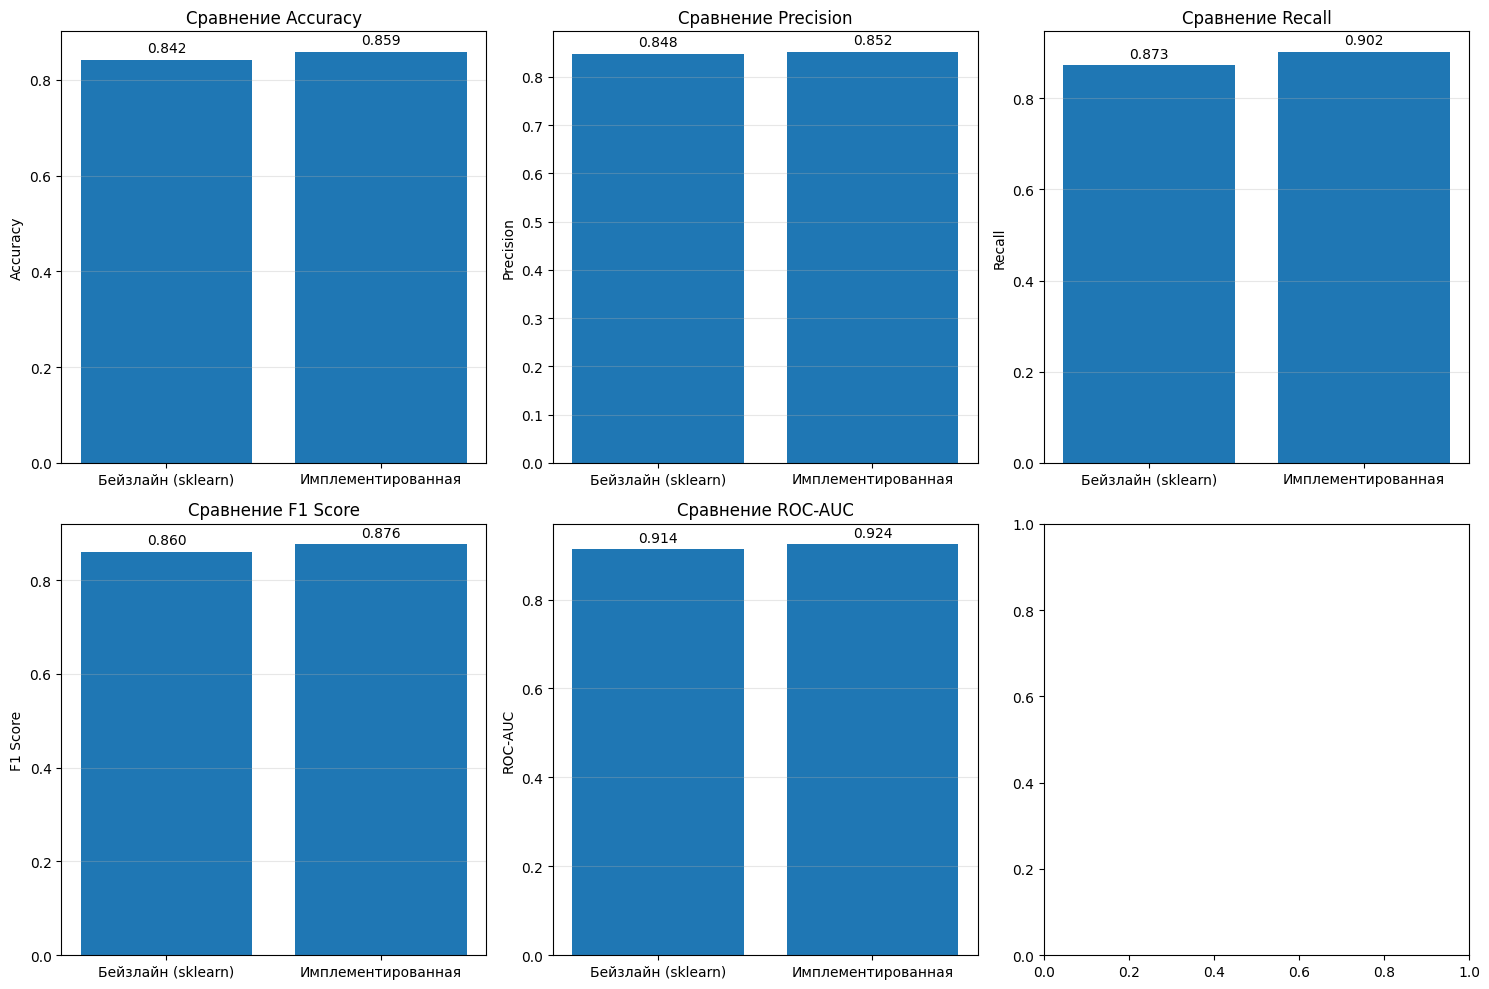

In [56]:
comparison_implemented = pd.DataFrame({
    'Модель': ['Бейзлайн (sklearn)', 'Имплементированная'],
    'Accuracy': [
        accuracy_score(y_test_c, y_pred_c),
        accuracy_score(y_test_c, y_pred_my)
    ],
    'Precision': [
        precision_score(y_test_c, y_pred_c),
        precision_score(y_test_c, y_pred_my)
    ],
    'Recall': [
        recall_score(y_test_c, y_pred_c),
        recall_score(y_test_c, y_pred_my)
    ],
    'F1 Score': [
        f1_score(y_test_c, y_pred_c),
        f1_score(y_test_c, y_pred_my)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test_c, y_pred_proba_c),
        roc_auc_score(y_test_c, y_pred_proba_my)
    ]
})

print("\nСравнение имплементированной модели с бейзлайном:")
print(comparison_implemented.to_string(index=False))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for i, metric in enumerate(metrics):
    row, col = i // 3, i % 3
    axes[row, col].bar(comparison_implemented['Модель'], comparison_implemented[metric])
    axes[row, col].set_title(f'Сравнение {metric}')
    axes[row, col].set_ylabel(metric)
    axes[row, col].grid(axis='y', alpha=0.3)
    
    for j, v in enumerate(comparison_implemented[metric]):
        axes[row, col].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Улучшим модель

In [57]:
improved_preprocessor_for_my = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

X_train_improved = improved_preprocessor_for_my.fit_transform(X_train_c)
X_test_improved = improved_preprocessor_for_my.transform(X_test_c)

my_rf_improved = CustomRandomForest(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

print("Обучение улучшенной имплементированной модели...")
my_rf_improved.fit(X_train_improved, y_train_c.values)

y_pred_my_improved = my_rf_improved.predict(X_test_improved)
y_pred_proba_my_improved = my_rf_improved.predict_proba(X_test_improved)[:, 1]

print("\nКачество улучшенной имплементированной модели:")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_my_improved):.4f}")
print(f"Precision: {precision_score(y_test_c, y_pred_my_improved):.4f}")
print(f"Recall: {recall_score(y_test_c, y_pred_my_improved):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_my_improved):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_my_improved):.4f}")

Обучение улучшенной имплементированной модели...

Качество улучшенной имплементированной модели:
Accuracy: 0.8587
Precision: 0.8455
Recall: 0.9118
F1 Score: 0.8774
ROC-AUC: 0.9311


### Сравним с кастомным бейзлайном


Итоговое сравнение всех моделей:
                       Модель  Accuracy  Precision   Recall  F1 Score  ROC-AUC
           Бейзлайн (sklearn)  0.842391   0.847619 0.872549  0.859903 0.913618
         Улучшенная (sklearn)  0.853261   0.850467 0.892157  0.870813 0.925933
           Имплементированная  0.858696   0.851852 0.901961  0.876190 0.923960
Имплементированная улучшенная  0.858696   0.845455 0.911765  0.877358 0.931074


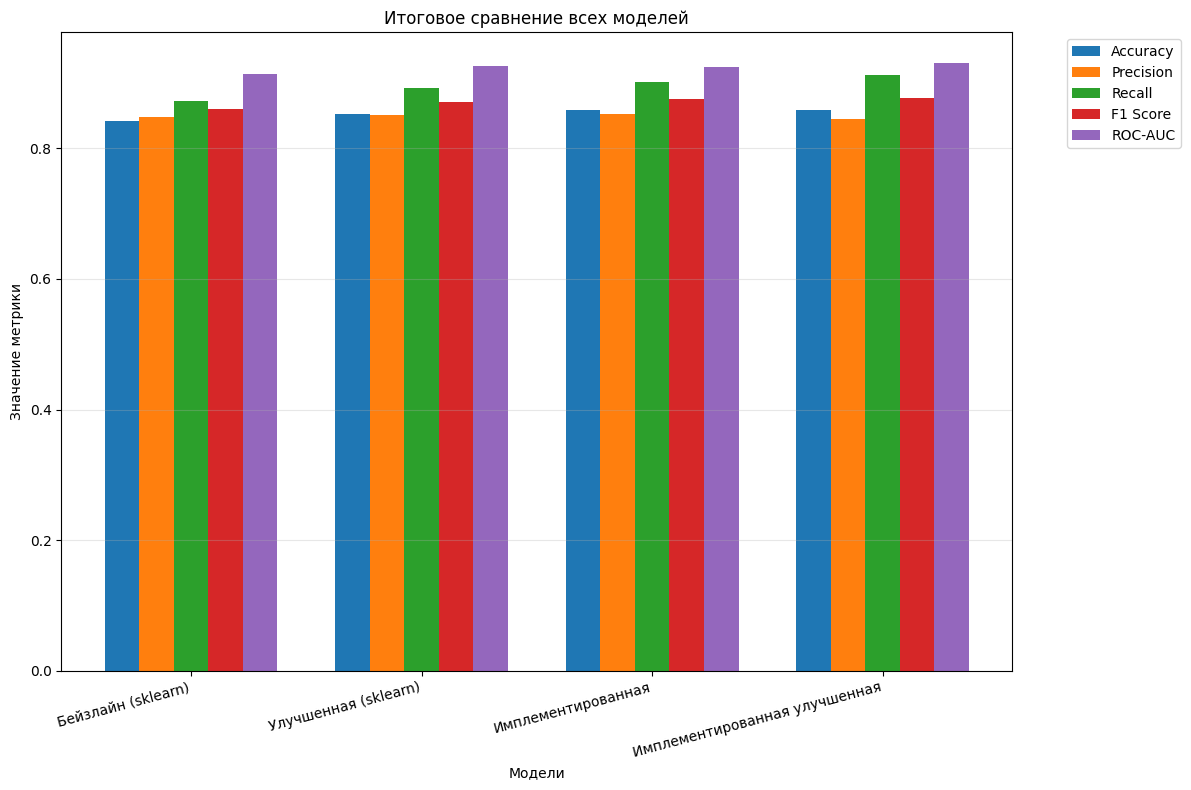

In [58]:
final_comparison = pd.DataFrame({
    'Модель': [
        'Бейзлайн (sklearn)', 
        'Улучшенная (sklearn)',
        'Имплементированная',
        'Имплементированная улучшенная'
    ],
    'Accuracy': [
        accuracy_score(y_test_c, y_pred_c),
        accuracy_score(y_test_c, y_pred_improved),
        accuracy_score(y_test_c, y_pred_my),
        accuracy_score(y_test_c, y_pred_my_improved)
    ],
    'Precision': [
        precision_score(y_test_c, y_pred_c),
        precision_score(y_test_c, y_pred_improved),
        precision_score(y_test_c, y_pred_my),
        precision_score(y_test_c, y_pred_my_improved)
    ],
    'Recall': [
        recall_score(y_test_c, y_pred_c),
        recall_score(y_test_c, y_pred_improved),
        recall_score(y_test_c, y_pred_my),
        recall_score(y_test_c, y_pred_my_improved)
    ],
    'F1 Score': [
        f1_score(y_test_c, y_pred_c),
        f1_score(y_test_c, y_pred_improved),
        f1_score(y_test_c, y_pred_my),
        f1_score(y_test_c, y_pred_my_improved)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test_c, y_pred_proba_c),
        roc_auc_score(y_test_c, y_pred_proba_improved),
        roc_auc_score(y_test_c, y_pred_proba_my),
        roc_auc_score(y_test_c, y_pred_proba_my_improved)
    ]
})

print("\nИтоговое сравнение всех моделей:")
print(final_comparison.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(final_comparison['Модель']))
width = 0.15

metrics_final = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, (metric, color) in enumerate(zip(metrics_final, colors)):
    ax.bar(x + i*width - 2*width, final_comparison[metric], width, label=metric, color=color)

ax.set_xlabel('Модели')
ax.set_ylabel('Значение метрики')
ax.set_title('Итоговое сравнение всех моделей')
ax.set_xticks(x)
ax.set_xticklabels(final_comparison['Модель'], rotation=15, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Выводы

In [59]:
print("\n1. Результаты бейзлайн модели (Random Forest):")
print(f"   - F1 Score: {f1_score(y_test_c, y_pred_c):.4f}")
print(f"   - ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_c):.4f}")

print("\n2. Улучшенная модель показала лучшие результаты:")
print(f"   - Улучшение F1 Score: {f1_score(y_test_c, y_pred_improved) - f1_score(y_test_c, y_pred_c):.4f}")
print(f"   - Улучшение ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_improved) - roc_auc_score(y_test_c, y_pred_proba_c):.4f}")

print("\n3. Имплементированная модель:")
print(f"   - F1 Score имплементированной модели: {f1_score(y_test_c, y_pred_my):.4f}")
print(f"   - Разница с бейзлайном sklearn: {f1_score(y_test_c, y_pred_my) - f1_score(y_test_c, y_pred_c):.4f}")

print("\n4. Улучшенная имплементированная модель:")
print(f"   - F1 Score улучшенной имплементированной модели: {f1_score(y_test_c, y_pred_my_improved):.4f}")
print(f"   - Разница с бейзлайном имплементированной модели: {f1_score(y_test_c, y_pred_my_improved) - f1_score(y_test_c, y_pred_my):.4f}")


1. Результаты бейзлайн модели (Random Forest):
   - F1 Score: 0.8599
   - ROC-AUC: 0.9136

2. Улучшенная модель показала лучшие результаты:
   - Улучшение F1 Score: 0.0109
   - Улучшение ROC-AUC: 0.0123

3. Имплементированная модель:
   - F1 Score имплементированной модели: 0.8762
   - Разница с бейзлайном sklearn: 0.0163

4. Улучшенная имплементированная модель:
   - F1 Score улучшенной имплементированной модели: 0.8774
   - Разница с бейзлайном имплементированной модели: 0.0012
